# Setup

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
%cd /content/drive/MyDrive/Colab Notebooks/cs230/womens_edu

/content/drive/MyDrive/Colab Notebooks/cs230/womens_edu


In [65]:
!git add womens_edu_regressor.ipynb 

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../sustainbench/sustainbench/download_datasets.py
	modified:   data_preprocessing.ipynb
	modified:   womens_edu_regressor.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../sustainbench/dhs/
	Tables and Figures.gdoc
	data/
	pretrained_resnet/

no changes added to commit (use "git add" and/or "git commit -a")


In [64]:
!git config --global user.email "disaaldan@gmail.com"
!git config --global user.name "disaalda"

In [ ]:
import argparse
import logging
import os

import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from skimage import io, transform
from sklearn.metrics import r2_score

In [ ]:
SAVE_NAME = "/content/drive/MyDrive/Colab Notebooks/cs230/womens_edu/pretrained_resnet/"

In [ ]:
if not os.path.exists(SAVE_NAME):
    os.makedirs(SAVE_NAME)
logging.basicConfig(filename=SAVE_NAME + '/log', level=logging.DEBUG)
writer = SummaryWriter(SAVE_NAME)

In [ ]:
dataset_root_dir = '/content/drive/MyDrive/Colab Notebooks/cs230/womens_edu/data/'

In [ ]:
df = pd.read_csv(os.path.join(dataset_root_dir, 'TJ_satellite.csv'))

# Satellite Imagery

##ImgDataset

In [ ]:
df.head()

,DHSID_EA,year,women_edu,path
0,TJ-2012-6#-00000001,2012,11.620690,/content/drive/MyDrive/Colab Notebooks/cs230/w...
1,TJ-2012-6#-00000002,2012,8.689655,/content/drive/MyDrive/Colab Notebooks/cs230/w...
2,TJ-2012-6#-00000003,2012,7.909091,/content/drive/MyDrive/Colab Notebooks/cs230/w...
3,TJ-2012-6#-00000004,2012,10.571429,/content/drive/MyDrive/Colab Notebooks/cs230/w...
4,TJ-2012-6#-00000005,2012,10.103448,/content/drive/MyDrive/Colab Notebooks/cs230/w...


In [ ]:
def split_train_val_test(df, train_yr, val_yr, test_yr):
  df['year'] = pd.to_numeric(df['year'])
  train_df = df[ df['year'] <= train_yr  ]
  val_df = df[ (df['year'] > train_yr) & (df['year'] <= val_yr) ]
  test_df = df[ (df['year'] > val_yr) & (df['year'] <= test_yr) ]
  return train_df, val_df, test_df 

In [ ]:
train, val, test = split_train_val_test(df, 2012, 2012, 2017)

In [ ]:
print(len(train))
print(len(val))
print(len(test))

343
0
365


In [ ]:
# TO DO LATER 
# define the training transforms and augmentations
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df, device):
        self.img_paths = df['path'].to_numpy()
        self.targets = df['women_edu'].to_numpy()
        self.device = device

    def __len__(self):
        return self.img_paths.shape[0]

    def __getitem__(self, idx):
        image = io.imread(self.img_paths[idx])
        image = image[:3,:,:] # truncate from 8 to 3 channels
        image_tensor = torch.from_numpy(image)      
        target = torch.Tensor(np.array([self.targets[idx]]))
        return image_tensor, target

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_imgs = ImgDataset(train, device)

In [ ]:
train_imgs[0][1]

tensor([11.6207])

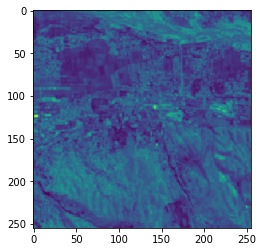

In [ ]:
plt.imshow(train_imgs[0][0][1])

## Model 

In [ ]:
def create_model(model):
    if model == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model == 'resnet34':
        model = models.resnet34(pretrained=True)
    elif model == 'resnet50':
        model = models.resnet50(pretrained=True)
    model.fc1 = nn.Sequential(nn.Linear(512, 100), nn.ReLU())
    model.fc2 = nn.Sequential(nn.Linear(100, 1), nn.ReLU())
    return model

In [ ]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        target = target.cpu().detach().numpy()
        pred = output.cpu().detach().numpy()
        #print("target ", target.shape)
        #print("pred", pred.shape)
        #r2 = r2_score(target, pred, multioutput='uniform_average')
        
        if batch_idx % 5 == 0:
            print("batch id", batch_idx)
            print("loss item", loss.item())
            #print("r squared", r2)
            # logging.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tR2: {:.4f}'.format(
            #     epoch, batch_idx * len(data), len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item(),
            #      r2))
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tR2: {:.4f}'.format(
            #     epoch, batch_idx * len(data), len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item(), 
            #     r2))
            #writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)
            #writer.add_scalar('R2/train', r2, epoch * len(train_loader) + batch_idx)

In [ ]:
def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    total = 0
    y_true = np.array([])
    y_pred = np.array([])
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            total += target.size(0)
            output = model(data)
            target = target.cpu().detach().numpy().squeeze()
            pred = output.cpu().detach().numpy().squeeze()
            y_true = np.append(y_true, target)
            y_pred = np.append(y_pred, pred)
    r2 = r2_score(y_true, y_pred)

    logging.info('\nTest set: R2: {:.4f}\n'.format(r2)) 
    print('\nTest set: R2: {:.4f}\n'.format(r2))
    writer.add_scalar('R2/test', r2, epoch * total)
    return r2, y_true, y_pred

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Preparing the dataloader')
df = pd.read_csv(os.path.join(dataset_root_dir, 'TJ_satellite.csv'))
train_df, val_df, test_df = split_train_val_test(df, 2012, 2012, 2018)

train_imgs = ImgDataset(train_df, device)
test_imgs = ImgDataset(test_df, device)
train_loader = DataLoader(train_imgs, batch_size=BATCH_SIZE, num_workers=2)
test_loader = DataLoader(test_imgs, batch_size=BATCH_SIZE, num_workers=2)

model = create_model('resnet18').to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

Preparing the dataloader


In [60]:
print('Starting training')
best_r2 = 0.
r2 = -1

for epoch in range(1, NUM_EPOCHS+1):
  train(model, device, train_loader, optimizer, criterion, epoch)
  #r2, y_true, y_pred = test(model, device, val_loader, criterion, epoch)
  if r2 >= best_r2:
    best_r2 = r2
    torch.save(model.state_dict(), args.save_name + "/model")
    logging.info("\nSaved model with R2: {:.4f}\n".format(best_r2))
        
    logging.info("\nBest R2: {:.4f}\n".format(best_r2))
    print("\nBest R2: {:.4f}\n".format(best_r2))

Starting training


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


batch id 0
loss item 118.02619934082031
batch id 5
loss item 57.98211669921875


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([23, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


batch id 10
loss item 12.904999732971191
batch id 0
loss item 21.02199935913086
batch id 5
loss item 2.126221179962158
batch id 10
loss item 7.793002128601074
batch id 0
loss item 1.9606949090957642
batch id 5
loss item 0.9972788691520691
batch id 10
loss item 3.9230101108551025
batch id 0
loss item 1.7916226387023926
batch id 5
loss item 1.0259555578231812
batch id 10
loss item 4.235426425933838
batch id 0
loss item 1.2176048755645752
batch id 5
loss item 0.6132267117500305
batch id 10
loss item 3.463050365447998
batch id 0
loss item 0.9819732904434204
batch id 5
loss item 0.37651872634887695
batch id 10
loss item 3.228503704071045
batch id 0
loss item 0.5537664294242859
batch id 5
loss item 0.389904260635376
batch id 10
loss item 2.30932879447937
batch id 0
loss item 1.1786640882492065
batch id 5
loss item 0.4892693758010864
batch id 10
loss item 2.435598611831665
batch id 0
loss item 0.7684061527252197
batch id 5
loss item 0.4593892991542816
batch id 10
loss item 2.5772414207458496


In [ ]:
# Saves the predictions
preds_df = pd.DataFrame({ 'womens_edu': y_true, 'womens_edu_pred': y_pred})
preds_df.to_csv(args.save_name + '/womens_edu_satellite_preds.csv', index=False)

In [ ]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('Getting the clusters')
    train_f = open('train_clusters_ia.txt', 'r')
    val_f = open('val_clusters_ia.txt', 'r')
    train_clusters = [x[:-1] for x in train_f.readlines()]
    val_clusters = [x[:-1] for x in val_f.readlines()]
    train_f.close()
    val_f.close()

    print('Preparing the dataloader')
    df = pd.read_csv('data.csv')
    train_df = df.loc[df['unique_cluster'].isin(train_clusters)]
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    val_df = df.loc[df['unique_cluster'].isin(val_clusters)]
    val_df = val_df.sample(frac=1).reset_index(drop=True)

    train_dataset = ImgDataset(train_df, device)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=2)
    val_dataset = ImgDataset(val_df, device)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=2)

    model = create_model().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-6)

    if not args.eval_mode:
        print('Starting training')
        best_r2 = 0.
        for epoch in range(1, args.num_epochs+1):
            train(model, device, train_loader, optimizer, criterion, epoch)
            r2, y_true, y_pred = test(model, device, val_loader, criterion, epoch)
            if r2 >= best_r2:
                best_r2 = r2
                torch.save(model.state_dict(), args.save_name + "/model")
                logging.info("\nSaved model with R2: {:.4f}\n".format(best_r2))
        
        logging.info("\nBest R2: {:.4f}\n".format(best_r2))
        print("\nBest R2: {:.4f}\n".format(best_r2))
    else:
        r2, y_true, y_pred = test(model, device, val_loader, criterion, 1)
        print("\nVal R2: {:.4f}\n".format(best_r2))

    # Saves the predictions
    df = pd.DataFrame({'unique_cluster': val_clusters,
                   args.label: y_true,
                   args.label + 'pred': y_pred})
    df.to_csv(args.save_name + '/' + args.label + '_preds.csv', index=False)

##Main

In [ ]:
if __name__ == "__main__":
    main() 


# Street-Level Imagery 

In [ ]:
df = pd.read_csv(os.path.join(dataset_root_dir, 'KY_cleaned.csv'))
#df = df.iloc[:1000,]
df.head()

,Unnamed: 0,DHSID_EA,country_code,year,path,women_edu
0,0,KY-2012-6#-00000210,KY,2012,/content/drive/MyDrive/Colab Notebooks/cs230/w...,9.909091
1,1,KY-2012-6#-00000210,KY,2012,/content/drive/MyDrive/Colab Notebooks/cs230/w...,9.909091
2,2,KY-2012-6#-00000210,KY,2012,/content/drive/MyDrive/Colab Notebooks/cs230/w...,9.909091
3,3,KY-2012-6#-00000210,KY,2012,/content/drive/MyDrive/Colab Notebooks/cs230/w...,9.909091
4,4,KY-2012-6#-00000210,KY,2012,/content/drive/MyDrive/Colab Notebooks/cs230/w...,9.909091


In [ ]:
len(df)

1105

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df, device, transform):
        self.img_paths = df['path'].to_numpy()
        self.targets = df['women_edu'].to_numpy()
        self.device = device
        self.transform = transform

    def __len__(self):
        return self.img_paths.shape[0]

    def __getitem__(self, idx):
        # TO DO: apply transformations 
        #image = Image.open(self.img_paths[idx])
        #image_tensor = self.transform(image)
        #image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor)

        image = io.imread(self.img_paths[idx]) 
        image_tensor = torch.from_numpy(image)
        image_tensor = image_tensor.permute(2,0,1).float()
        target = torch.Tensor(np.array([self.targets[idx]]))
        return image_tensor, target

In [ ]:
import math 
split = math.floor(0.8*len(df))
train_df = df.iloc[:split,].sample(frac=1, random_state=1234)
test_df = df.iloc[split:, ].sample(frac=1, random_state=1234) 

In [ ]:
train_imgs = ImgDataset(train_df, device, transform=transform)
test_imgs = ImgDataset(test_df, device, transform=transform)

In [ ]:
train_imgs[50][0][2]

tensor([[20.4178, 29.3067, 38.1956,  ..., 15.9733, 15.9733, 24.8622],
        [29.3067, 29.3067, 38.1956,  ..., 15.9733, 15.9733, 11.5289],
        [24.8622, 29.3067, 42.6400,  ..., 15.9733, 15.9733, 11.5289],
        ...,
        [51.5289, 55.9733, 60.4178,  ..., 51.5289, 51.5289, 51.5289],
        [51.5289, 51.5289, 55.9733,  ..., 51.5289, 51.5289, 47.0844],
        [47.0844, 47.0844, 51.5289,  ..., 51.5289, 51.5289, 51.5289]])

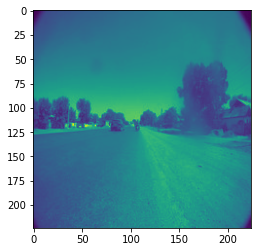

In [ ]:
plt.imshow(train_imgs[0][0][1])

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 0.01
NUM_EPOCHS = 10

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
    print('Preparing the dataloader')
    df = pd.read_csv(os.path.join(dataset_root_dir, 'KY_cleaned.csv'))
    #train_df, val_df, test_df = split_train_val_test(df, 2013, 2013, 2018)

    train_imgs = ImgDataset(train_df, device, transform)
    test_imgs = ImgDataset(test_df, device, transform)
    train_loader = DataLoader(train_imgs, batch_size=BATCH_SIZE, num_workers=2)
    test_loader = DataLoader(test_imgs, batch_size=BATCH_SIZE, num_workers=2)

    model = create_model('resnet18').to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

Preparing the dataloader


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
    print('Starting training')
    best_r2 = 0.
    r2 = -1
    for epoch in range(1, NUM_EPOCHS+1):
        #print(epoch)
        train(model, device, train_loader, optimizer, criterion, epoch)
        r2, y_true, y_pred = test(model, device, test_loader, criterion, epoch)
        if r2 >= best_r2:
            best_r2 = r2
            torch.save(model.state_dict(), args.save_name + "/model")
            logging.info("\nSaved model with R2: {:.4f}\n".format(best_r2))
        
        logging.info("\nBest R2: {:.4f}\n".format(best_r2))
        print("\nBest R2: {:.4f}\n".format(best_r2))

Starting training
Train Epoch: 1 [0/884 (0%)]	Loss: 121.943321	R2: -175.4902
Train Epoch: 1 [80/884 (9%)]	Loss: 117.581810	R2: -132.1338
Train Epoch: 1 [160/884 (18%)]	Loss: 130.057434	R2: -111.4962
Train Epoch: 1 [240/884 (27%)]	Loss: 115.543823	R2: -124.5112
Train Epoch: 1 [320/884 (36%)]	Loss: 120.172882	R2: -182.7129
Train Epoch: 1 [400/884 (45%)]	Loss: 115.530861	R2: -213.5522
Train Epoch: 1 [480/884 (54%)]	Loss: 118.645844	R2: -107.3214
Train Epoch: 1 [560/884 (62%)]	Loss: 125.503143	R2: -92.1065
Train Epoch: 1 [640/884 (71%)]	Loss: 115.949036	R2: -106.5396
Train Epoch: 1 [720/884 (80%)]	Loss: 120.076668	R2: -159.2183
Train Epoch: 1 [800/884 (89%)]	Loss: 117.718613	R2: -130.4007
Train Epoch: 1 [220/884 (98%)]	Loss: 138.564880	R2: -574.5672

Test set: R2: -220.6029


Best R2: 0.0000

Train Epoch: 2 [0/884 (0%)]	Loss: 121.943321	R2: -175.4902
Train Epoch: 2 [80/884 (9%)]	Loss: 117.581810	R2: -132.1338
Train Epoch: 2 [160/884 (18%)]	Loss: 130.057434	R2: -111.4962
Train Epoch: 2 [240